In [14]:
# !pip install pandas

In [15]:
from minio import Minio
import duckdb
import pandas as pd
import numpy as np

In [16]:
ACCESS_KEY = "RkX19daoA4QpeUytwGna"
SECRET_ACCESS_KEY = "jIr2nk8MPaT6xUn5p9qFuSZISg36ykrqXlP2lyjs"
STORAGE_OPTIONS = {
        "key": ACCESS_KEY,
        "secret": SECRET_ACCESS_KEY,
        "endpoint_url": "http://minio-api-svc"}

client = Minio(
    "minio-api-svc",
    access_key=ACCESS_KEY,
    secret_key=SECRET_ACCESS_KEY,
    secure=False
)
## api reference
## https://min.io/docs/minio/linux/developers/python/API.html



connection = duckdb.connect()
connection.execute("INSTALL httpfs")
connection.execute("LOAD httpfs")
connection.execute("SET s3_region='us-east-1'")
connection.execute("SET s3_access_key_id='KhjA5yMeOPzDWDyh'")
connection.execute("SET s3_secret_access_key='PTzHBYNc1HmO3TNdKN3IjUIJx3Q5VS5m'")
connection.execute("SET s3_endpoint='minio-api-svc';")
connection.execute("SET s3_use_ssl=false")
connection.execute("SET s3_url_style=path")


## 1. Load Raw Dataset

In [17]:
bucket_name = "crawled-top10-november2" #CONTAINS ALL RAW DATA
image_bucket_name = "images-november" #IMAGE NAME IS ID


In [18]:
## using MINIO API

In [19]:
objects = client.list_objects(bucket_name)

In [20]:
object_names = []
for i in objects:
    object_names.append(i.object_name)

In [21]:
## all the files containing the data collect in november
object_names

['crawl_data-1699752053874-0.parquet',
 'crawl_data-1699752404593-0.parquet',
 'crawl_data-1699752785810-0.parquet',
 'crawl_data-1699753170053-0.parquet',
 'crawl_data-1699753562033-0.parquet',
 'crawl_data-1699753949253-0.parquet',
 'crawl_data-1699754340445-0.parquet',
 'crawl_data-1699754730866-0.parquet',
 'crawl_data-1699755127746-0.parquet',
 'crawl_data-1699755519078-0.parquet',
 'crawl_data-1699755914478-0.parquet',
 'crawl_data-1699756315889-0.parquet',
 'crawl_data-1699756705969-0.parquet',
 'crawl_data-1699757096477-0.parquet',
 'crawl_data-1699757490044-0.parquet',
 'crawl_data-1699757880692-0.parquet',
 'crawl_data-1699758282959-0.parquet',
 'crawl_data-1699758711856-0.parquet',
 'crawl_data-1699759192095-0.parquet',
 'crawl_data-1699759650986-0.parquet',
 'crawl_data-1699760107191-0.parquet',
 'crawl_data-1699760582991-0.parquet',
 'crawl_data-1699761048878-0.parquet',
 'crawl_data-1699761510219-0.parquet',
 'crawl_data-1699762006342-0.parquet',
 'crawl_data-169976248662

In [9]:
## using duckdb

In [32]:
dfs = []

for i in range(300, 310):
    df = connection.execute(f"SELECT * FROM parquet_scan('s3://{bucket_name}/{object_names[i]}');").df() #remove what does not have price
    dfs.append(df)
    
concatenated_df = pd.concat(dfs, ignore_index=True)

In [46]:
concatenated_df = concatenated_df[~concatenated_df["image_path"].isnull()]
concatenated_df.reset_index(drop=True, inplace=True)

In [47]:
concatenated_df.columns

Index(['url', 'title', 'text', 'domain', 'name', 'description', 'image',
       'retrieved', 'production_data', 'category', 'price', 'currency',
       'seller', 'seller_type', 'seller_url', 'location', 'ships to', 'id',
       'loc_name', 'lat', 'lon', 'country', 'image_path', 'predicted_label'],
      dtype='object')

In [48]:
len(concatenated_df["image_path"])

11334

In [43]:
from PIL import Image
from io import BytesIO

In [64]:
image_data = client.get_object(image_bucket_name, df["image_path"][0])
image_bytes = image_data.read()
image = Image.open(BytesIO(image_bytes)).convert("RGB")

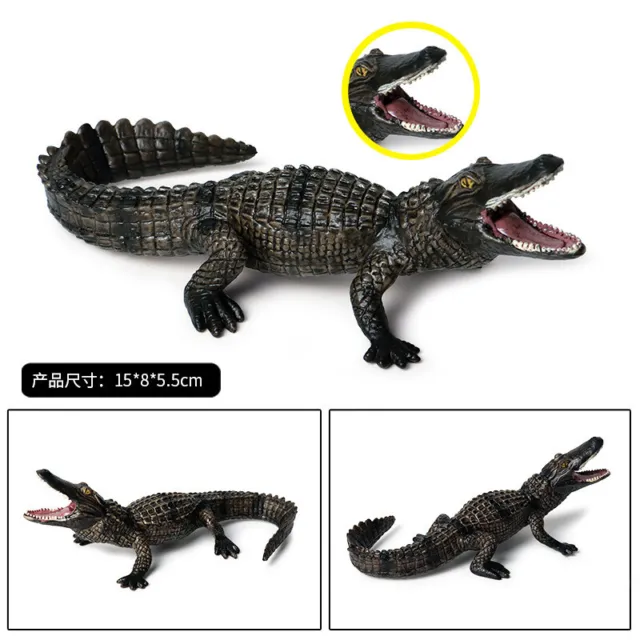

In [65]:
image

In [76]:
from tqdm import tqdm

In [77]:
saved_img_folder = "images"

for i in tqdm(range(len(concatenated_df))):
    image_path = concatenated_df["image_path"][i]
    image_data = client.get_object(image_bucket_name, image_path)
    
    image_bytes = image_data.read()
    image = Image.open(BytesIO(image_bytes)).convert("RGB")
    image.save(f'{saved_img_folder}/{image_path}')

100%|██████████| 11334/11334 [25:17<00:00,  7.47it/s] 


## 2. Cluster text+image based on topics

In [38]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
from PIL import Image
from io import BytesIO

In [39]:
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torchvision.transforms import transforms
import torch.nn as nn
import torch
from transformers import BertModel, RobertaModel, DistilBertModel
from torchvision.models import resnet50
from torch import cuda
import time
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torchvision import models
import torch.nn.functional as F
from io import BytesIO
import torch.optim as optim

In [ ]:
!pip install hdbscan --only-binary=:all:

In [ ]:
!pip install bertopic

In [78]:
from bertopic import BERTopic
from bertopic.representation import VisualRepresentation

# Additional ways of representing a topic
visual_model = VisualRepresentation()

# Make sure to add the `visual_model` to a dictionary
representation_model = {
   "Visual_Aspect":  visual_model,
}

topic_model = BERTopic(representation_model=representation_model, verbose=True)
docs = concatenated_df['title']
images = ['images/'+path for path in concatenated_df['image_path']]

topics, probs = topic_model.fit_transform(documents=docs, images=images)

2024-05-03 02:27:09,966 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/355 [00:00<?, ?it/s]

2024-05-03 02:27:33,742 - BERTopic - Embedding - Completed ✓
2024-05-03 02:27:33,743 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-03 02:27:50,346 - BERTopic - Dimensionality - Completed ✓
2024-05-03 02:27:50,350 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-03 02:27:50,987 - BERTopic - Cluster - Completed ✓
2024-05-03 02:27:50,995 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 325/325 [00:43<00:00,  7.39it/s]
2024-05-03 02:28:36,615 - BERTopic - Representation - Completed ✓


In [80]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("bertopic-docs-image", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

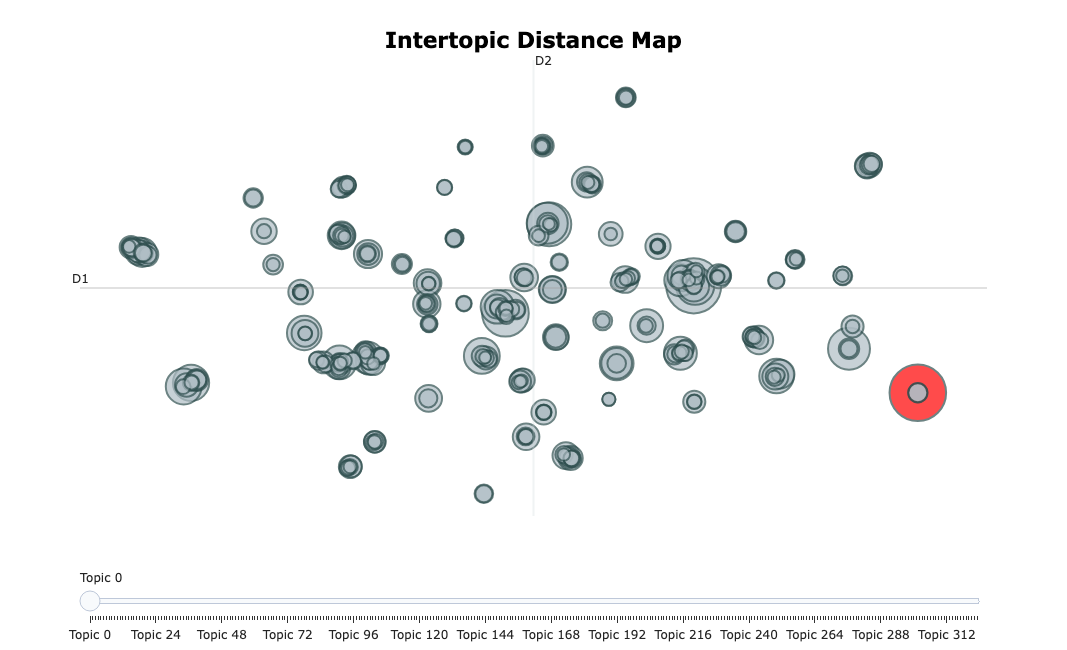

In [84]:
topic_model.visualize_topics()

In [82]:
import base64
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract dataframe
df2 = topic_model.get_topic_info().drop("Representative_Docs", axis=1).drop("Name", axis=1)

# Visualize the images
a = HTML(df2.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))
html = a.data
with open('html_file.html', 'w') as f:
    f.write(html)

In [96]:
topics[:10]

[-1, -1, 2, 2, 32, 298, 103, 32, 224, 2]

In [ ]:
!pip install openpyxl

In [111]:
import pandas as pd

topic_labels_df = pd.read_excel('labels.xlsx')
topic_labels_df.index = topic_labels_df.index - 1
topic_labels_dict = topic_labels_df.dropna().to_dict()['Labels']

In [112]:
topic_labels_df

Labels
-1       NaN
 0       0.0
 1       NaN
 2       0.0
 3       1.0
...      ...
 319     1.0
 320     0.0
 321     0.0
 322     0.0
 323     1.0

[325 rows x 1 columns]

In [117]:
topics_arr = np.array(topics)
concatenated_df['psuedo_label'] = [topic_labels_dict[t] if t in topic_labels_dict.keys() else None for t in topics_arr]

In [126]:
df_clean = concatenated_df.dropna(subset=['psuedo_label'])
df_clean.reset_index(drop=True, inplace=True)
print(len(df_clean))

8413


## 3. Train classifier and evaluate on unseen data

In [127]:
from bertopic.backend import MultiModalBackend

model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

docs = df_clean['title']
images = ['images/'+path for path in df_clean['image_path']]

clip_embeddings = model.embed(docs, images, verbose=True)

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (93 > 77). Running this sequence through the model will result in indexing errors
100%|██████████| 263/263 [05:22<00:00,  1.23s/it]


In [129]:
clip_embeddings.shape

(8413, 512)

In [136]:
clip_embeddings[:5]

array([[ 1.28143206e-02,  3.74323130e-02, -1.45383999e-02, ...,
         9.36719328e-01, -1.11587346e-04, -2.48951733e-01],
       [-1.64817158e-01, -2.77241781e-01, -7.30079636e-02, ...,
         1.13848287e+00, -6.75728917e-03,  7.59406388e-03],
       [-1.90480620e-01, -1.80152278e-01,  1.67964924e-01, ...,
         5.41853741e-01,  2.42115349e-01, -1.42632991e-01],
       [-1.64760046e-01,  2.13499941e-01, -9.97337401e-02, ...,
         4.73461121e-01, -1.25070736e-01, -2.02118702e-01],
       [-5.79098612e-03,  1.67332549e-01,  2.35621914e-01, ...,
         1.78706363e-01,  6.79664984e-02,  2.28256121e-01]])

In [131]:
saved_img_folder = "test_images"
test_df = pd.read_parquet("data_labeled_feb_7_2024.parquet")
image_bucket_name = "images-october"

for i in tqdm(range(len(test_df))):
    image_path = test_df["image_path"][i]
    image_data = client.get_object(image_bucket_name, image_path)
    
    image_bytes = image_data.read()
    image = Image.open(BytesIO(image_bytes)).convert("RGB")
    image.save(f'{saved_img_folder}/{image_path}')

100%|██████████| 1750/1750 [06:11<00:00,  4.71it/s]


In [132]:
test_df = test_df.dropna(subset = ["title"])
test_docs = test_df['title']
test_images = ['test_images/'+path for path in test_df['image_path']]

clip_embeddings_test = model.embed(test_docs, test_images, verbose=True)

100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


In [200]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(clip_embeddings, df_clean['psuedo_label'])

# Predict and evaluate
y_pred = classifier.predict(clip_embeddings_test)
y_test = test_df['expert_label']
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8729885057471264


In [201]:
y_pred_train = classifier.predict(clip_embeddings)
y_train = df_clean['psuedo_label']
print("Accuracy:", accuracy_score(y_train, y_pred_train))

Accuracy: 1.0


In [156]:
def visualize_confusion_matrix(y_true, y_pred):
    cf_matrix=confusion_matrix(y_true, y_pred)
    labels = [['True Negative', 'False Positive'],['False Negative', 'True Positive']]

    sns.heatmap(cf_matrix, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
    sns.heatmap(cf_matrix, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Display the plot
    plt.show()

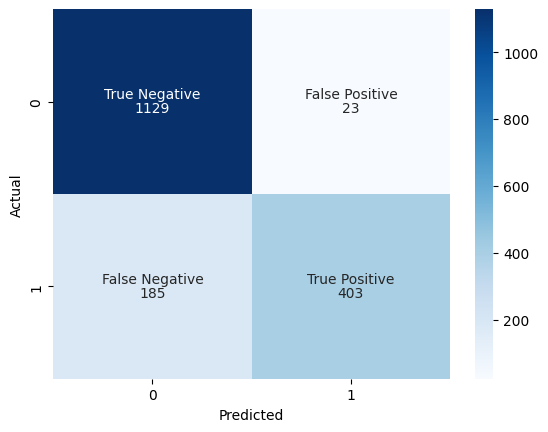

In [157]:
visualize_confusion_matrix(y_test, y_pred)

In [162]:
import umap
reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(clip_embeddings_test)
umap_embedding.shape

(1740, 2)

In [173]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(clip_embeddings_test)

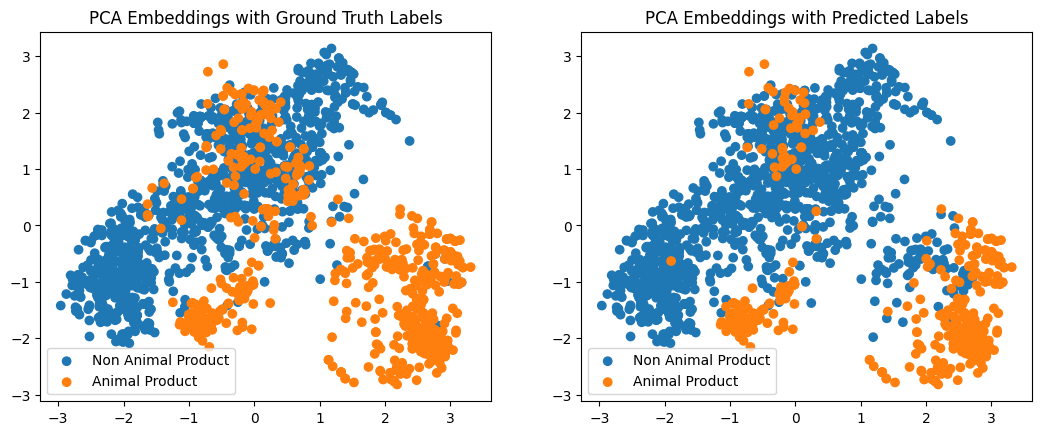

In [193]:
plt.figure(figsize=(12.8, 4.8))

plt.subplot(1, 2, 1)
plt.scatter(
    pca_embedding[:, 0][y_test == 0],
    pca_embedding[:, 1][y_test == 0],
    c=[sns.color_palette()[int(x)] for x in y_test[y_test == 0]], label="Non Animal Product")
plt.scatter(
    pca_embedding[:, 0][y_test == 1],
    pca_embedding[:, 1][y_test == 1],
    c=[sns.color_palette()[int(x)] for x in y_test[y_test == 1]], label="Animal Product")
plt.title("PCA Embeddings with Ground Truth Labels")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    pca_embedding[:, 0][y_pred == 0],
    pca_embedding[:, 1][y_pred == 0],
    c=[sns.color_palette()[int(x)] for x in y_pred[y_pred == 0]], label="Non Animal Product")
plt.scatter(
    pca_embedding[:, 0][y_pred == 1],
    pca_embedding[:, 1][y_pred == 1],
    c=[sns.color_palette()[int(x)] for x in y_pred[y_pred == 1]], label="Animal Product")
plt.title("PCA Embeddings with Predicted Labels")
plt.legend()

plt.show()

In [211]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print(f"Precision: {recall} Recall: {precision}, accuracy: {accuracy}, f1_score: {f1score}")

Precision: 0.6717687074829932 Recall: 0.933806146572104, accuracy: 0.8729885057471264, f1_score: 0.781404549950544


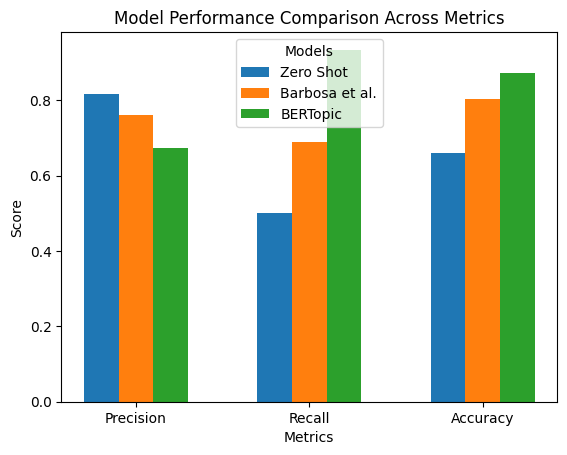

In [212]:
models = ['Zero Shot', 'Barbosa et al.', 'BERTopic']
metrics = ['Precision', 'Recall', 'Accuracy']
performance = {
    'Zero Shot': [0.8163265306122449, 0.4994797086368366, 0.6607142857142857],
    'Barbosa et al.': [0.7602040816326531, 0.6887519260400616, 0.8028735632183908],
    'BERTopic': [0.6717687074829932, 0.933806146572104, 0.8729885057471264],
}

# Number of models
num_models = len(models)
# Number of metrics
num_metrics = len(metrics)
# Set width for each bar
bar_width = 0.2

# X positions of each group of bars
indices = np.arange(num_metrics)

# Plot each model's performance
for i, model in enumerate(models):
    plt.bar(indices + bar_width * i, performance[model], bar_width, label=model)

# Set labels and titles
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison Across Metrics')
plt.xticks(indices + bar_width * (num_models - 1) / 2, metrics)
plt.legend(title="Models")

# Show the plot
plt.show()

In [141]:
!pip install tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 186.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 1.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 KB 354.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 18.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 660.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 17.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [150]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
import os

# Define the number of input features and output classes
num_features = 512  # Replace with the number of input features in your dataset
num_classes = 2  # Replace with the number of classes in your classification task

log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the MLP model
model = Sequential([
    Dense(units=256, activation='relu', input_shape=(num_features,)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Prepare your training and testing data
# X_train, y_train = ... (your training data)
# X_test, y_test = ... (your testing data)

# Convert labels to one-hot encoded vectors
y_train_one_hot = tf.keras.utils.to_categorical(df_clean['psuedo_label'], num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(test_df['expert_label'], num_classes)

history = model.fit(clip_embeddings, y_train_one_hot, epochs=50, batch_size=32,
                    validation_data=(clip_embeddings_test, y_test_one_hot),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(clip_embeddings_test, y_test_one_hot)
print(f'Test accuracy: {test_acc}')




Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8999 - loss: 0.2475 - val_accuracy: 0.8868 - val_loss: 0.3333
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9751 - loss: 0.0695 - val_accuracy: 0.8856 - val_loss: 0.4266
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9894 - loss: 0.0328 - val_accuracy: 0.8649 - val_loss: 0.5689
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9943 - loss: 0.0189 - val_accuracy: 0.8810 - val_loss: 0.6579
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9955 - loss: 0.0151 - val_accuracy: 0.8609 - val_loss: 0.7128
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9961 - loss: 0.0136 - val_accuracy: 0.8655 - val_loss: 0.9479
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9934 - loss: 0.0198 - val_accuracy: 0.8793 - val_loss: 0.7652
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.

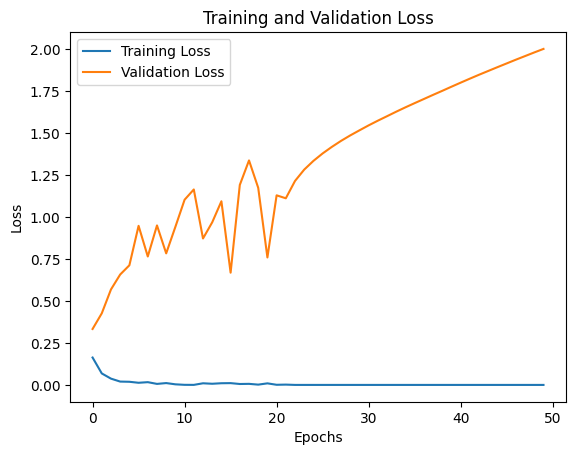

In [151]:


# Train the model with TensorBoard callback
# history = model.fit(clip_embeddings, y_train_one_hot, epochs=100, batch_size=32,
#                     validation_data=(clip_embeddings_test, y_test_one_hot),
#                     callbacks=[tensorboard_callback])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [152]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
import os

# Define the number of input features and output classes
num_features = 512  # Replace with the number of input features in your dataset
num_classes = 2  # Replace with the number of classes in your classification task

log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the MLP model
model = Sequential([
    Dense(units=256, activation='relu', input_shape=(num_features,)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Prepare your training and testing data
# X_train, y_train = ... (your training data)
# X_test, y_test = ... (your testing data)

# Convert labels to one-hot encoded vectors
y_train_one_hot = tf.keras.utils.to_categorical(df_clean['psuedo_label'], num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(test_df['expert_label'], num_classes)

history = model.fit(clip_embeddings, y_train_one_hot, epochs=30, batch_size=16,
                    validation_data=(clip_embeddings_test, y_test_one_hot),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(clip_embeddings_test, y_test_one_hot)
print(f'Test accuracy: {test_acc}')




Epoch 1/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9257 - loss: 0.2176 - val_accuracy: 0.8948 - val_loss: 0.3376
Epoch 2/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9765 - loss: 0.0709 - val_accuracy: 0.8885 - val_loss: 0.4140
Epoch 3/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9866 - loss: 0.0391 - val_accuracy: 0.8948 - val_loss: 0.4407
Epoch 4/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9916 - loss: 0.0301 - val_accuracy: 0.8626 - val_loss: 0.6091
Epoch 5/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9952 - loss: 0.0150 - val_accuracy: 0.8828 - val_loss: 0.8426
Epoch 6/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9955 - loss: 0.0150 - val_accuracy: 0.8799 - val_loss: 0.5531
Epoch 7/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9961 - loss: 0.0136 - val_accuracy: 0.8644 - val_loss: 0.6817
Epoch 8/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.

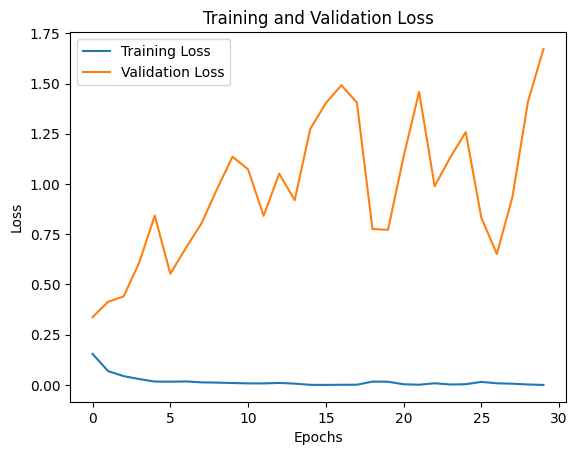

In [153]:

# Train the model with TensorBoard callback
# history = model.fit(clip_embeddings, y_train_one_hot, epochs=100, batch_size=32,
#                     validation_data=(clip_embeddings_test, y_test_one_hot),
#                     callbacks=[tensorboard_callback])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()